In [2]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
import json
import matplotlib.pyplot as plt
import os
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output
import numpy as np
from torchvision import transforms
import torchvision.transforms.functional as TF
import cv2
import torch.nn as nn
from torchvision.models.segmentation import lraspp_mobilenet_v3_large, LRASPP_MobileNet_V3_Large_Weights

# Define the model repository; here we use the popular Stable Diffusion v1.4
model_id = "CompVis/stable-diffusion-v1-4"

# Load the DDPM scheduler from the model repository
# Note: The 'subfolder="scheduler"' assumes that the model repo contains a scheduler config.
scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Create the Stable Diffusion pipeline with the DDPM scheduler
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,       # Inject the DDPM scheduler
    revision="fp16",           # Use the fp16 model weights if available for speed
    torch_dtype=torch.float16
)

# Move the pipeline to GPU if available
pipe.to("cuda")

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/diffusers/pipelines/pipeline_loading_utils.py:242: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(


Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/opt/conda/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis-

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [3]:
def show_images_grid(images, rows, cols, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")  # Hide axes
        else:
            ax.set_visible(False)  # Hide empty subplots

    plt.tight_layout()
    plt.show()

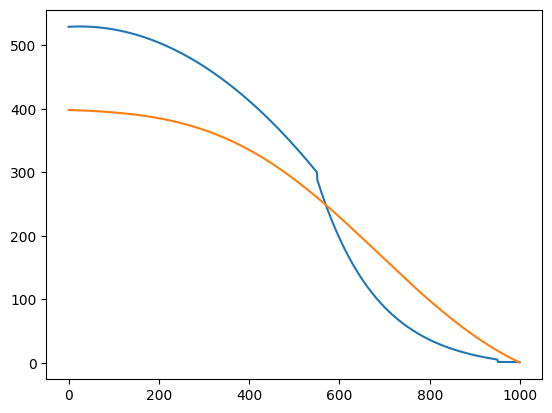

In [4]:
import numpy as np

#exp on different schedule

def custom_mapping(x):
    """
    Maps integers [1, 999] into a function in range [0, 400] with the specified properties:
    - f(1) = 400
    - f(999) = 0
    - Slow decrease from 1 to 700
    - Fast decrease from 700 to 900
    - Almost no change from 900 to 999
    """
    x = np.clip(x, 1, 999)  # Ensure x is within the range
    if x <= 550:
        return (-(x + 500) * (x - 550)/ 1200 + 300)   # Quadratic decay (slow)
    elif x <= 950:
        return 300 * np.exp(-1.5 * (x - 550) / 200) - 10  # Exponential decay (fast)
    else:
        return 300 * np.exp(-4) * (1 - 0.1 * (x - 900) / 99) - 4  # Almost constant


x_values = np.arange(0, 1000)
y_values = np.array([custom_mapping(x) for x in x_values])

plt.plot(y_values)
plt.plot(400 * (1 - pipe.scheduler.alphas_cumprod.cpu().numpy()[::-1]))

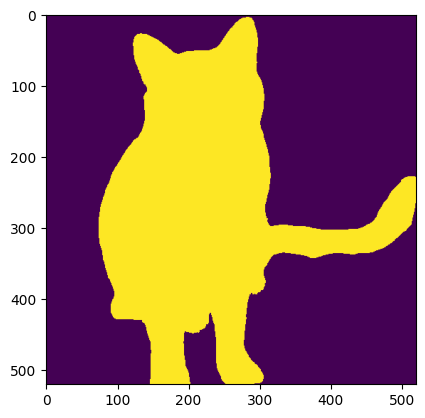

In [8]:
mask = transforms.ToTensor()(cv2.imread("/root/Universal-Guided-Diffusion/processed_data/cat/cat003_mask.jpg", cv2.IMREAD_GRAYSCALE) > 70)
mask = TF.resize(mask, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
plt.imshow(mask.permute(1, 2, 0))

In [13]:
criterion = nn.CrossEntropyLoss()
segmentator = lraspp_mobilenet_v3_large(LRASPP_MobileNet_V3_Large_Weights.DEFAULT).to("cuda:0")

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [14]:
# index in segmentator results
label_2_idx_map = {"cat": 8, "dog": 12}


In [15]:
cur_class = "cat"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10498047..1.0263672].


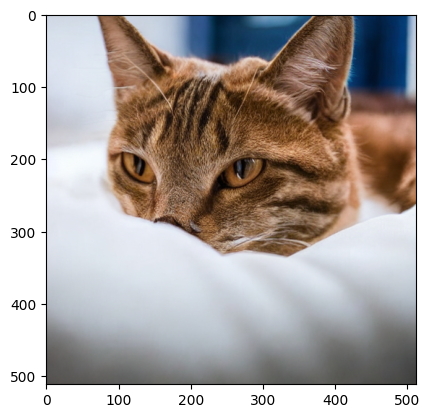

100%|██████████| 500/500 [4:43:47<00:00, 34.06s/it]


In [118]:
import json 
import os

with open(f"/root/Universal-Guided-Diffusion/processed_data/{cur_class}/annotations.json", "r") as f:
    annotations = json.load(f)

val, key = list(annotations.items())[2]

mask_path = f"/root/Universal-Guided-Diffusion/processed_data/{cur_class}/{val}_mask.jpg"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) > 70
mask = transforms.ToTensor()(mask)

h, w = mask.shape[1:]
max_size = max(h, w)
pad_h = (max_size - h) // 2
pad_w = (max_size - w) // 2

mask = TF.pad(mask, (pad_w, pad_h, pad_w + (w % 2), pad_h + (h % 2)), fill=0)

mask = TF.resize(mask, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
prop = key

device="cuda:0"
output_type = "pil"
guidance_scale = 2.5

height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = pipe.unet.config.sample_size * pipe.vae_scale_factor

num_images = 1

with torch.no_grad():
    prompt_embeds = pipe._encode_prompt(
        prop,
        device,
        num_images_per_prompt=num_images,
        do_classifier_free_guidance=True,
        negative_prompt=None,
        prompt_embeds=None,
        negative_prompt_embeds=None,
        lora_scale=None,
    )

# 4. Prepare timesteps
num_inference_steps = 500
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
timesteps = pipe.scheduler.timesteps

# 5. Prepare latent variables
num_channels_latents = pipe.unet.config.in_channels
latents = pipe.prepare_latents(
num_images,
num_channels_latents,
height,
width,
prompt_embeds.dtype,
device,
generator=None,
latents=None,
)
latents.requires_grad_(False)

trans = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

k = 10
m = 30
saver = []
# 7. Denoising loop
for i, t in tqdm(enumerate(timesteps), total=num_inference_steps):
    for _ in range(k):
        z_t = latents.detach().clone()
        latent_model_input = z_t.repeat(2, 1, 1, 1) # classifier free guidance
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = pipe.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                cross_attention_kwargs=None,
                return_dict=False,
            )[0]

        # classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        alpha_prod_t = pipe.scheduler.alphas_cumprod[timesteps[i]]
        alpha_prod_t_prev = pipe.scheduler.alphas_cumprod[timesteps[i + 1]] if i + 1 < len(timesteps) else torch.tensor(1.0)

        pipe.vae.zero_grad()
        segmentator.zero_grad()

        z_zero = (z_t - (1 - alpha_prod_t) ** 0.5 * noise_pred) / alpha_prod_t ** 0.5
            # backward pass
        delta_z = torch.zeros(z_zero.shape, device=device, requires_grad=True, dtype=z_zero.dtype)
        optim = torch.optim.SGD([delta_z], lr=0.075)

        for _ in range(m):
            img = pipe.vae.decode((z_zero + delta_z) / pipe.vae.config.scaling_factor, return_dict=False)[0]
            map = (img + 1) * 0.5
            map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
            map = trans(map)
            seg_logits = segmentator(map.to("cuda:0").float())['out']
            class8_logits = seg_logits[:, label_2_idx_map[cur_class], :, :]
            optim.zero_grad()
            loss = torch.nn.functional.binary_cross_entropy_with_logits(class8_logits, mask.to("cuda:0").expand(num_images, 520, 520).float())
            saver.append(loss.detach().cpu())
            loss.backward()
            torch.nn.utils.clip_grad_norm_([delta_z], 10)
            optim.step()

        noise_pred -= (alpha_prod_t / (1 - alpha_prod_t)) ** 0.5 * delta_z.detach()


        # compute the previous noisy sample x_t -> x_t-1
        next_latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
        latents = (alpha_prod_t/alpha_prod_t_prev)**0.5 * next_latents \
            + (1 - alpha_prod_t/alpha_prod_t_prev)**0.5 * torch.randn_like(next_latents)
    latents = next_latents

    if (i % 10): # fix
        with torch.no_grad():
            plt.close()
            clear_output()
            image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

            map = (image + 1) * 0.5
            # map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
            # map = trans(map)

            plt.imshow(map.cpu()[0].permute(1,2,0).float())
            plt.show()

            # plt.imsave(f"/root/results/{t}_{val}_mask.jpg", 
            #         image.cpu()[0].permute(1,2,0))

            # images = pipe.image_processor.postprocess(image.detach(), output_type=output_type, do_denormalize=[True] * num_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10498047..1.0263672].


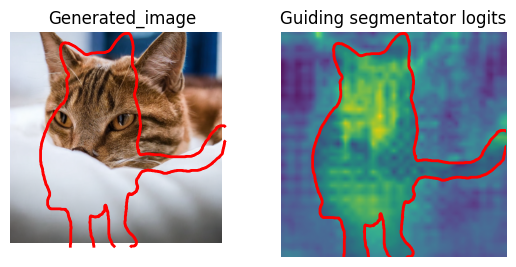

In [ ]:
from skimage import measure

contours = measure.find_contours(mask[0].cpu().numpy(), level=0.5)

with torch.no_grad():
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

    map = (image + 1) * 0.5
    map = TF.resize(map, (520, 520), interpolation=TF.InterpolationMode.BILINEAR)
    map = trans(map)
    seg_logits = segmentator(map.to("cuda:0").float())['out']
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Generated image")
    plt.imshow(((image + 1) * 0.5).cpu()[0].permute(1,2,0).float())
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

    # plt.axis("off")
    
    # plt.imshow(seg_logits.cpu()[0][8].float())
    plt.subplot(1,2,2)
    plt.title("Guiding segmentator logits")
    plt.axis("off")
    plt.imshow(seg_logits.cpu()[0][8].float())
    

# Plot contours
    for contour in contours:
        plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

    plt.imshow(mask[0], alpha=0.1, cmap="Reds")
    plt.show()